# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

*Посмотрим, у каких руководителей сотрудники имеют высокие оценки производительности, и количество таких сотрудников.*

*Для анализа отберем три типа сотрудников: Exceeds, Exceptional, Fully Meets.*

In [5]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

str_sql = """select "Manager Name", "Performance Score", sum(estimation) 
from (select "Manager Name", "Performance Score", count("Performance Score") as estimation
from (select hd."Employee Name", hd."Manager Name", hd."Performance Score" from hr_dataset hd
left join production_staff ps using ("Employee Name")) as f
group by "Manager Name", "Performance Score") as t
where ("Performance Score" = 'Exceptional' or "Performance Score" = 'Exceeds' or "Performance Score" ='Fully Meets')
group by "Manager Name", "Performance Score" order by "Manager Name", sum desc;"""

cursor.execute(str_sql)
production_staff = [i for i in cursor.fetchall()]
cursor.close()

df = pd.DataFrame(production_staff, columns=["Manager Name", "Performance Score", "count_Employees"])
df.head()

,Manager Name,Performance Score,count_Employees
0,Alex Sweetwater,Fully Meets,4
1,Alex Sweetwater,Exceptional,1
2,Alex Sweetwater,Exceeds,1
3,Amy Dunn,Fully Meets,11
4,Amy Dunn,Exceeds,2


In [6]:
df = df.groupby(['Manager Name', 'Performance Score'])['count_Employees']\
    .agg(lambda x: int(x))\
    .unstack()\
    .fillna(0)\
    .reset_index()\
    .sort_values(by=['Exceeds', 'Fully Meets'])

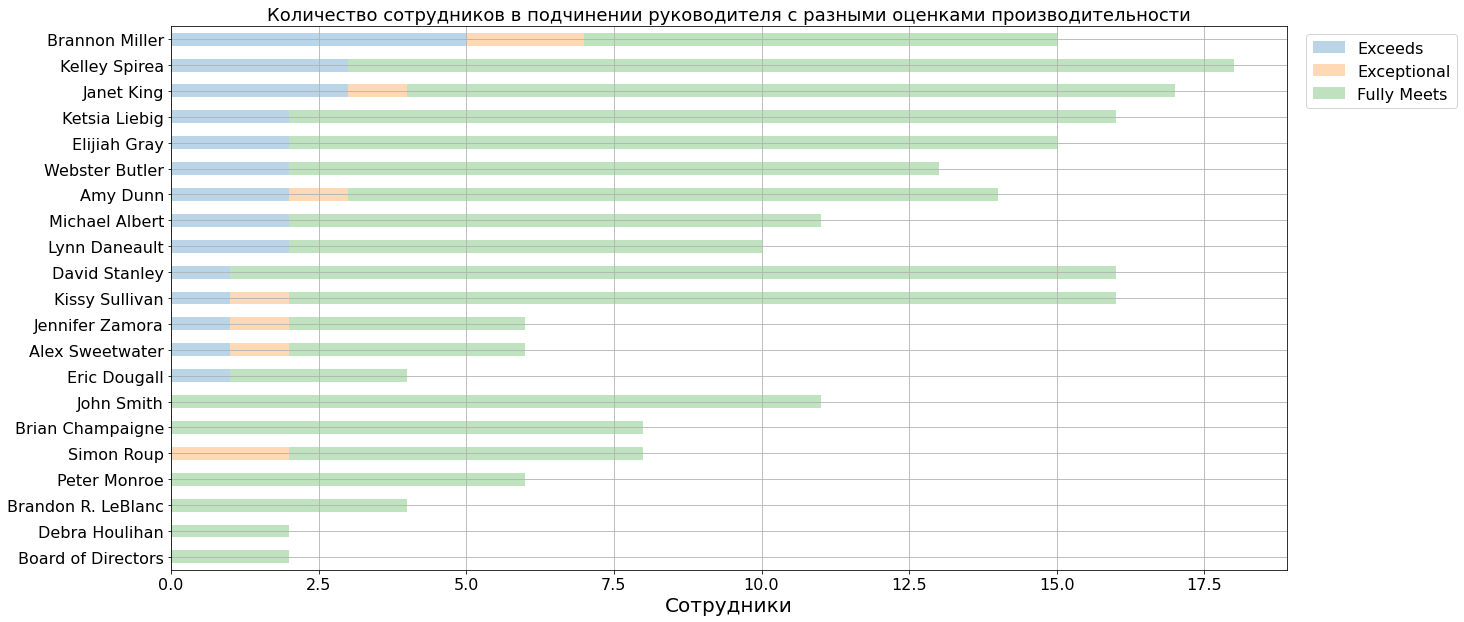

In [6]:
plot = df.plot.barh(
        x='Manager Name'
        , figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Количество сотрудников в подчинении руководителя с разными оценками производительности'
        , alpha=0.3
        )

plot.title.set_size(18)
plot.legend(loc=0, bbox_to_anchor=(1.01, 1), fontsize=16)
plot.set(ylabel=None)
plt.xlabel("Сотрудники", fontsize=20)
plt.grid()

plt.show()

*Стоит обратить внимание на руководителей, у которых среди сотрудников имеются талантливые (**Exceptional**), и сотрудники, которые перевыполняют свою работу (**Exceeds**).* 

*Посмотрим, сотрудники с каким статусом семейного положения работают дольше всего в компании.*

In [7]:
pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

str_sql = """select maritaldesc, sum("Days Employed") as "Days Employed" from hr_dataset group by maritaldesc 
order by "Days Employed" desc;"""

cursor.execute(str_sql)
production_staff = [i for i in cursor.fetchall()]
cursor.close()

df = pd.DataFrame(production_staff, columns=["maritaldesc", "Days Employed"])
df

,maritaldesc,Days Employed
0,Single,188067
1,Married,153287
2,Divorced,33086
3,Separated,20441
4,Widowed,6904


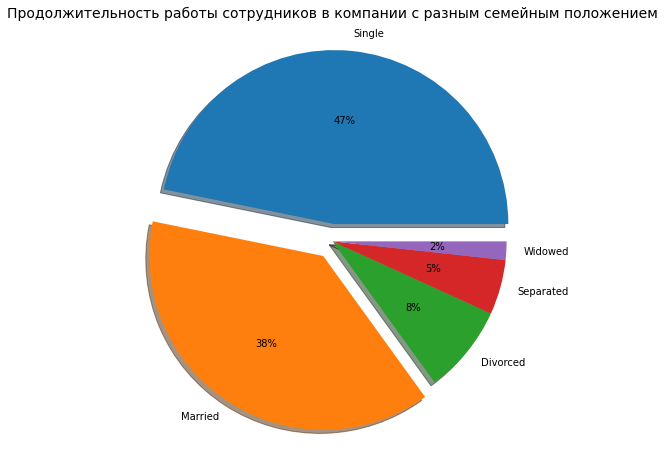

In [8]:
plt.figure(figsize=(10,8))
plt.pie(df['Days Employed'], labels=df.maritaldesc, autopct='%1.0f%%', shadow=1, explode = (0.1, 0.1, 0, 0, 0))
plt.title('Продолжительность работы сотрудников в компании с разным семейным положением', fontsize=14)

plt.show()

*Самые высокие показатели продолжительности работы в компании у сотрудников со статусами семейного положения "холостой" (**Single**) и "женат(замужем)" (**Married**).*

*Посмотрим, сотрудники каких возрастов работают дольше всего в компании.*

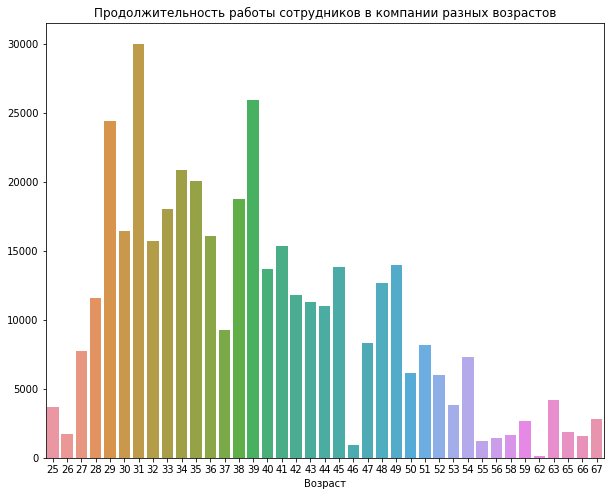

In [9]:
pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

str_sql = """select age, sum("Days Employed") as "Days Employed" from hr_dataset group by age order by age desc;"""

cursor.execute(str_sql)
production_staff = [i for i in cursor.fetchall()]
cursor.close()

df = pd.DataFrame(production_staff, columns=["age", "Days Employed"])

import seaborn as sns
        
plt.figure(figsize=(10,8))
sns.barplot(df.age, df['Days Employed'])
plt.title("Продолжительность работы сотрудников в компании разных возрастов")
plt.xlabel("Возраст")
plt.ylabel('')
plt.show()

*Тенденция продолжительности работы сотрудников в компании является нисходящей при повышении возраста. Самые высокие показатели отмечаются между возрастом 29 - 39 годами, также более стабильные средние показатели между возрастом 40 - 50 годами.*

*Рекомендации для HR-отдела:*  
* *Забивать штат сотрудников сначала тех руководителей, у которых в команде талантливые, и перевыполняющие свою работу, сотрудники.*
* *Руководители, у которых сотрудники имеют низкие показатели, могут перенять навыки управления у более опытных управляющих.*
* *Присматриваться к кандидатам со статусами семейного положения "холостой", "женат(замужем)".*
* *Присматриваться к кандидатам возраста 29 - 39 лет, т.к. они показывают лучшую продолжительнось работы в компании, и возраста 40 - 50 лет, они показывают стабильные средние показатели.*

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

In [10]:
import requests
from datetime import datetime, timedelta, time
import re
import pymorphy2

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

*Выгрузим последние 100 постов из паблика Skillbox Вконтакте для анализа работы SMM-отдела за последнее время.*

In [11]:
vk_token = ""
url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&count=100&v=5.92'
response = getjson(url)

*Посчитаем общее количество лайков и комментариев за два периода по времени публикации: до 14:00 и после 14:00.*

In [12]:
count_likes = 0
count_comments = 0
count_likes_ = 0
count_comments_ = 0

for i in range(100):
    
    date = datetime.fromtimestamp(response['response']['items'][i]['date']).time()
    likes = response['response']['items'][i]['likes']['count']
    comments = response['response']['items'][i]['comments']['count']
    
#     print(f'Время публикации: {date}', '\n', f'Лайки: {likes}', '\n', f'Комментарии: {comments}', '\n', 
#           '===============================', '\n', sep="")

    if date < time(14):
        count_likes += likes
        count_comments += comments
    else:
        count_likes_ += likes
        count_comments_ += comments

print(f"до 14:00 ==>>> \n\tколичество лайков: {count_likes}\n\tколичество комментариев: {count_comments}\n\nпосле 14:00 ==>>> \
      \n\tколичество лайков: {count_likes_}\n\tколичество комментариев: {count_comments_}")

до 14:00 ==>>> 
	количество лайков: 4078
	количество комментариев: 438

после 14:00 ==>>>       
	количество лайков: 3861
	количество комментариев: 456


*По количеству лайков и комментариев видим, что в обоих периодах вовлеченность пользователей одинаковая, т.е. после 14:00 активность не падает.*

*Проанализируем две рубрики: Skillbox-программирование и Skillbox-управление.* 

In [13]:
regular_expr = r'[Ss]killbox_+[Пп]рограммирование|[Ss]killbox_+[Уу]правление|[Пп]рограммирование_+[Ss]killbox|\
[Уу]правление_+[Ss]killbox'
reg_expr_compiled = re.compile(regular_expr)

for i in range(100):
    
    text = response['response']['items'][i]['text']
    likes = response['response']['items'][i]['likes']['count']
    comments = response['response']['items'][i]['comments']['count']
    reposts = response['response']['items'][i]['reposts']['count']
    
    if len(reg_expr_compiled.findall(text)):
        
        print(f'Пост №{i + 1} - Рубрика: {reg_expr_compiled.findall(text)[0]}', '\n','\n', 
                  text[:50] + '...', '\n',
                  'Лайки:', likes, '\n',
                  'Комментарии', comments, '\n',
                  'Репосты:', reposts, '\n', datetime.fromtimestamp(response['response']['items'][i]['date']), '\n',
                  '==========================',  '\n')

Пост №1 - Рубрика: Skillbox_программирование 
 
 Когда увидели прикольную картинку: ну, неплохо.
Ко... 
 Лайки: 72 
 Комментарии 3 
 Репосты: 3 
 2020-09-05 13:42:27 

Пост №3 - Рубрика: Skillbox_программирование 
 
 Продолжаем изучать HTML! Сегодня разберем теги для... 
 Лайки: 63 
 Комментарии 0 
 Репосты: 1 
 2020-09-04 13:32:56 

Пост №5 - Рубрика: Skillbox_Программирование 
 
 Представьте, что вы — директор компании и наняли н... 
 Лайки: 50 
 Комментарии 0 
 Репосты: 9 
 2020-09-02 20:19:39 

Пост №6 - Рубрика: Skillbox_управление 
 
 Посмотреть на текст и сразу понять, о чем речь. Мг... 
 Лайки: 114 
 Комментарии 8 
 Репосты: 11 
 2020-09-02 18:16:50 

Пост №14 - Рубрика: Программирование_Skillbox 
 
 3D-дизайнер Рейчел (@rachaellic) каждый день публи... 
 Лайки: 177 
 Комментарии 27 
 Репосты: 9 
 2020-08-28 15:27:35 

Пост №15 - Рубрика: Skillbox_Программирование 
 
 "Подскажите, как пройти в библиотеку?" — что-то из... 
 Лайки: 56 
 Комментарии 16 
 Репосты: 7 
 2020-08-27 19

*Представлены две рубрики: **Skillbox-программирование** и **Skillbox-управление**. Постов из рубрики **Skillbox-программирование** значительно больше. В постах рубрики **Skillbox-управление** видна активная воволеченность пользователей по количеству лайков и репостов.* 

*Рекомендации для SMM-отдела - увеличить количество публикаций по рубрике **Skillbox-управление**.*